In [1]:
import jax.numpy as jnp
from jax import random
from melvin import LaplaceApproximation
import jax
import matplotlib.pylab as plt
from functools import partial

jax.config.update("jax_enable_x64", True)

In [2]:
SEED = random.PRNGKey(123068)
N_ROWS = 200
N_PARAMS = 20
NOISE_AMPLITUDE = 2.0

In [3]:
SEED, _seed = random.split(SEED)
true_params = jax.random.normal(key=_seed, shape=(N_PARAMS,))
print(f"True parameters\n{true_params}")

SEED, _seed = random.split(SEED)
X = jax.random.normal(key=_seed, shape=(N_ROWS, N_PARAMS))
print(f"\nFirst 2 rows of data\n{X[:2,:]}")

SEED, _seed = random.split(SEED)
eps = NOISE_AMPLITUDE*jax.random.normal(key=_seed, shape=(N_ROWS,))
y = X @ true_params + eps
print(f"\nFirst 2 labels\n{y[:2]}")

True parameters
[-0.41959653 -0.515441    0.29349301 -1.08905649  0.81179762  1.60976376
 -1.32718381  0.36175878 -1.65091768  0.72506684  0.32725878 -1.15274689
 -1.64335485 -1.25164681  1.36635926  0.63472409  0.42828669 -0.01882997
 -0.77914543  0.49000033]

First 2 rows of data
[[ 1.12425312  1.20534369 -1.49134698 -0.797011   -0.8784741  -0.92112943
  -0.76324367 -0.14223209  0.43083118  0.39633834 -2.00550183  1.14734086
  -0.97638592 -0.60403735 -0.28984657 -0.22324324  0.34924965  0.82033834
  -0.83760291 -1.30904016]
 [ 0.89877167 -1.14499604  0.42068895  0.11273099 -0.61621765  0.0912808
   0.25485903 -0.49365265 -0.24655109 -0.908175    1.78042556  0.72285995
   0.37207329  0.46716234  2.13434933  0.37722536 -1.85845726  0.81766798
   0.00409695 -1.11364174]]

First 2 labels
[-2.12118451  1.43767218]


In [4]:
class BayesianLinearModel(LaplaceApproximation):
    param_bounds = jnp.array([[0.0, jnp.nan]] + [[jnp.nan, jnp.nan]]*N_PARAMS)

    def model(self, params, X):
        weights = params[1:]
        return X @ weights

    def posterior_log_prob(self, params, y, y_pred):
        noise = params[0]
        log_like = jax.scipy.stats.norm.logpdf(y, loc=y_pred, scale=noise)
        return jnp.sum(log_like)

SEED, _seed = random.split(SEED)
initial_weights = jax.random.normal(key=_seed, shape=(N_PARAMS,))
initial_noise = jnp.array([0.5])
initial_params = jnp.concatenate([initial_noise, initial_weights])

model = BayesianLinearModel(
    name="Bayesian Linear Model",
    initial_params=initial_params,
    X=X,
    y=y,
)
print(model)

Laplace Approximation: Bayesian Linear Model
Fixed Parameters: []
Fit converged successfully
Fitted Parameters: 
[
  1.8546539943110145 +/- 0.0927326975277519,	 [Lower Bound = 0.0]
  -0.3817698891544954 +/- 0.14940820998055898,
  -0.6289526543283256 +/- 0.1442008419018779,
  0.24525489693683522 +/- 0.14138853329635145,
  -1.0461039453717658 +/- 0.12648523479413115,
  1.0260560968113808 +/- 0.1282591224471687,
  1.3743565944092073 +/- 0.14776729356970567,
  -1.2281225055994764 +/- 0.1462867161125212,
  0.4848238600312804 +/- 0.1357587780435841,
  -1.7849001701773695 +/- 0.1293783185200604,
  0.6737400050858101 +/- 0.13887299219447571,
  0.6493353006633238 +/- 0.14376426093402211,
  -1.0380168631634021 +/- 0.14766227218744177,
  -1.2232884909352335 +/- 0.13454095722822185,
  -1.2492738451325625 +/- 0.1450748428292767,
  1.4507676267513154 +/- 0.13036016828600924,
  0.7712693746112549 +/- 0.1199577644397335,
  0.5624961169698681 +/- 0.12903069395012873,
  -0.016707124557786657 +/- 0.13252

In [5]:
print(f"True parameters\n{true_params}")
print(f"\nFitted parameters\n{model.params.x[1:]}")

print(f"\nTrue noise\n{NOISE_AMPLITUDE}")
print(f"\nFitted noise\n{model.params.x[0]}")

True parameters
[-0.41959653 -0.515441    0.29349301 -1.08905649  0.81179762  1.60976376
 -1.32718381  0.36175878 -1.65091768  0.72506684  0.32725878 -1.15274689
 -1.64335485 -1.25164681  1.36635926  0.63472409  0.42828669 -0.01882997
 -0.77914543  0.49000033]

Fitted parameters
[-0.38176989 -0.62895265  0.2452549  -1.04610395  1.0260561   1.37435659
 -1.22812251  0.48482386 -1.78490017  0.67374001  0.6493353  -1.03801686
 -1.22328849 -1.24927385  1.45076763  0.77126937  0.56249612 -0.01670712
 -0.82278409  0.44370942]

True noise
2.0

Fitted noise
1.8546539943110145


In [6]:
SEED, _seed = random.split(SEED,2)
samples = model.sample_params(prng_key = _seed, n_samples = 10000)

params_mean = jnp.mean(samples, axis=0)
params_low = jnp.percentile(samples, q=5, axis=0)
params_upp = jnp.percentile(samples, q=95, axis=0)

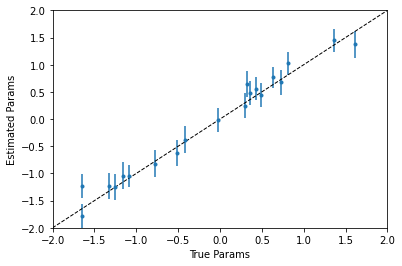

In [9]:
plt.errorbar(
    true_params, 
    model.params.x[1:], 
    yerr=(
        params_upp[1:] - params_mean[1:],
        params_mean[1:] - params_low[1:]
    ), 
    fmt="."
)
plt.plot(
    [-2, 2], [-2, 2], "k--", lw=1
)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel("True Params")
plt.ylabel("Estimated Params")
plt.show()